In [2]:
import ipdb
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
import pandas as pd
import matplotlib.pylab as pylab
import matplotlib as mpl
import cartopy
import cartopy.crs as ccrs
from utils import constants as cnst
from eod import msg
from utils import u_grid, u_interpolate as u_int, u_darrays as uda, u_arrays as ua
from utils import u_statistics as u_stats
import datetime
import matplotlib.colors as mcolors
from cartopy.io.shapereader import Reader
from cartopy.feature import ShapelyFeature
from utils import u_plot as uplot
import salem
import numpy.ma as ma
from scipy import stats, ndimage
import warnings
from scipy.ndimage.measurements import label
import shapely.geometry as shpg
import datetime
from scipy.stats import gaussian_kde, linregress
import pickle as pkl

pylab.rcParams['figure.figsize'] = (50., 50.)
%matplotlib inline

In [1]:
cd ..


/home/ck/pythonWorkspace/proj_CEH


In [3]:
fpath = cnst.network_data + 'figs/HUARAZ/'

In [3]:
corr_all = xr.open_dataset('/home/ck/DIR/mymachine/GRIDSAT/MCS18_peru/correlations/GRIDSAT-15_u_correlation_3dRolling_SouthAmerica_1985-2018_diffs.nc')
corr_all = corr_all.assign_coords(dayofyear=corr_all.dayofyear.values)
corr_all = corr_all.sel(latitude=slice(-25,0), longitude=slice(-81,-65))

In [4]:
def readERA(var):

    u200orig = xr.open_dataset('/media/ck/Elements/SouthAmerica/ERA5/hourly/'+var+'_15UTC_1981-2019_peru_big.nc')
    u200orig = uda.flip_lat(u200orig)
    datetimes = pd.to_datetime(u200orig.time.values)
    newtimes = []
    for t in datetimes:
        newtimes.append(t.replace(hour=0))
    u200orig['time'] = ('time', newtimes)
    return u200orig

In [5]:
era = readERA('u200')
era = era.sel(latitude=slice(-25,0), longitude=slice(-81,-65)).sel(time=((era['time.year']>=1985)&(era['time.year']<=2018)))

In [6]:
eraq8 = readERA('q850')
eraq8 = eraq8.sel(latitude=slice(-25,0), longitude=slice(-81,-65)).sel(time=((eraq8['time.year']>=1985)&(eraq8['time.year']<=2018))).load()

In [7]:
erav = readERA('v850')
erav = erav.sel(latitude=slice(-25,0), longitude=slice(-81,-65)).sel(time=((erav['time.year']>=1985)&(erav['time.year']<=2018))).load()

In [8]:
topo = xr.open_dataarray(cnst.TOPO_1MIN).sel(lon=slice(-81,-65), lat=slice(-25,0))
topo_on_g = corr_all.salem.lookup_transform(topo)

In [9]:
# def find_doy(corr_all, gt_doy=None, lt_doy=None):
    
#     if gt_doy is not None:
#         mask = corr_all.dayofyear>gt_doy
#         pindex = 0
#         rcheck = -60  #-60
#     if lt_doy is not None:
#         mask = corr_all.dayofyear<lt_doy
#         pindex = -1
#         rcheck = 60 #60
        
#     corr = corr_all.sel(dayofyear=mask)
#     corr_sig = corr.where(corr['pval']<=0.05)
   
#     array = corr_sig['r'].values

#     thresh = 0.1
#     array[array <= thresh] = 0  # T threshold maskout
#     array[np.isnan(array)] = 0  # set ocean nans to 0
#     outarr_3 = np.zeros((array.shape[1], array.shape[2]))
#     outarr_5 = np.zeros((array.shape[1], array.shape[2]))
#     outarr_max = np.zeros((array.shape[1], array.shape[2]))

#     for x in range(array.shape[2]):
#         for y in range(array.shape[1]):
            
#             ts = array[:,y,x]
#             labels, numL = label(ts)

#             u, inv = np.unique(labels, return_inverse=True)
#             n = np.bincount(inv)

#             inds_3 = u[(n>=3)&(u!=0)] ## min 3 days onset
#             inds_5 = u[(n>=5)&(u!=0)] ## min 5 days breakdown
            

#             if len(inds_3)>0:
#                 pos3 = np.where(labels==inds_3[pindex])
#                 day3 = ((corr_sig.dayofyear.values+1)[(pos3[0])[pindex]])
#             else:
#                 day3 = np.nan

#             if len(inds_5)>0:
#                 pos5 = np.where(labels==inds_5[pindex])
#                 day5 = ((corr_sig.dayofyear.values+1)[pos5[0][pindex]])
#             else:
#                 day5 = np.nan

#             if (pindex==0) & (np.sum(array[rcheck::,y,x]==0)/abs(rcheck)>0.85):  # remove pixels where more than 40 days in Nov/Dev have no correlation
#                 day3 = np.nan
#                 day5 = np.nan
#             if (pindex==-1) & (np.sum(array[::rcheck,y,x]==0)/abs(rcheck)>0.85): # remove pixels where more than 40 days in Jan/Feb have no correlation
#                 day3 = np.nan
#                 day5 = np.nan

#             outarr_3[y,x] = day3
#             outarr_5[y,x] = day5
#             outarr_max[y,x] = (corr_sig.dayofyear.values+1)[np.argmax(ts)]
            
#     outarr_3 = xr.DataArray(outarr_3, coords=[corr['latitude'], corr['longitude']], dims=['latitude','longitude'])
#     outarr_5 = xr.DataArray(outarr_5, coords=[corr['latitude'], corr['longitude']], dims=[ 'latitude','longitude'])
            
# #     grid = corr.salem.grid.regrid(factor=1)
# #     #ipdb.set_trace()
# #     outarr_3 = grid.lookup_transform(outarr_3)
# #     outarr_5 = grid.lookup_transform(outarr_5)
# #     grid = grid.to_dataset()
# #     outarr_3 = xr.DataArray(outarr_3, coords=[grid['y'], grid['x']], dims=['latitude','longitude'])
# #     outarr_5 = xr.DataArray(outarr_5, coords=[grid['y'], grid['x']], dims=['latitude','longitude'])

#     return outarr_3, outarr_5

In [10]:
# outarr_3, outarr_5 = find_doy(corr_all, gt_doy=213)  # doy 182 is 1st July
# endarr_3, endarr_5= find_doy(corr_all, lt_doy=213)
# o3 = outarr_3.values.copy()
# e5 = endarr_5.values.copy()

# # o3[topo_on_g<500]=np.nan
# # e5[topo_on_g<500]=np.nan
# start=np.nanmedian(o3, axis=1)
# end = np.nanmedian(e5, axis=1)

In [11]:
ch_on_era = xr.open_mfdataset('/media/ck/Elements/SouthAmerica/CHIRPS/SA_daily_onERA/CHIRPS_daily_onERA_*.nc')
chirps_doypick = ch_on_era['precip'].sel(time=((ch_on_era['time.year']>=1985)&(ch_on_era['time.year']<=2018))).sel(latitude=slice(-25,0), longitude=slice(-81,-65))
chirps_bimod = chirps_doypick#.rolling(time=30, min_periods=3, center=True).mean()#.where((chirps_doypick['time.month']!=8))

In [12]:
tir_on_era = xr.open_mfdataset('/home/ck/DIR/mymachine/GRIDSAT/MCS18_peru/daily_-15ALLkm2_UTC_DAY_onBIGERA/*.nc',
                                combine='nested', concat_dim='time')
tir_doypick = tir_on_era['tir'].sel(time=((tir_on_era['time.year']>=1985)&(tir_on_era['time.year']<=2018))).sel(latitude=slice(-25,0), longitude=slice(-81,-65))

In [13]:
tir_on_era

<xarray.Dataset>
Dimensions:    (latitude: 125, longitude: 97, time: 12908)
Coordinates:
  * time       (time) datetime64[ns] 1984-01-01 1984-01-02 ... 2019-09-30
  * longitude  (longitude) float32 -82.0 -81.75 -81.5 ... -58.5 -58.25 -58.0
  * latitude   (latitude) float32 -25.0 -24.75 -24.5 -24.25 ... 5.5 5.75 6.0
Data variables:
    tir        (time, latitude, longitude) float64 dask.array<chunksize=(31, 125, 97), meta=np.ndarray>
Attributes:
    pyproj_srs:  +proj=longlat +datum=WGS84 +no_defs

In [14]:
# regions = {
#     'equatorial' : [(-5,0)],
#     'transition' : [(-8,-5)],
#     'central' : [(-12,-8)],
#     'southern' : [(-18,-15)]}
# h = 2000

regions = {
'equatorial' : [(-5,0)],
'transition' : [(-8,-5)],
'central' : [(-12,-8)],
'southern' : [(-17,-15)]}
h = 2000

In [15]:
dic = pkl.load(open(cnst.network_data+ 'data/HUARAZ/saves/corr_GRIDSAT-15_start_end.p', "rb"))

In [16]:
dic.keys()

dict_keys(['start_3d', 'end_5d'])

In [17]:
lat_pick = corr_all.latitude.values
corr_start = dic['start_3d']
corr_end = dic['end_5d']

In [18]:
for r in regions.keys():
    mask = (lat_pick>(regions[r])[0][0]) & (lat_pick<=(regions[r])[0][1])
    sedoy = (np.mean(corr_start[mask]), np.mean(corr_end[mask]))
    regions[r].append(sedoy)

In [19]:
regions

{'equatorial': [(-5, 0),
  (<xarray.DataArray ()>
   array(248.08674304),
   <xarray.DataArray ()>
   array(149.39627329))],
 'transition': [(-8, -5),
  (<xarray.DataArray ()>
   array(262.92270531),
   <xarray.DataArray ()>
   array(130.59796438))],
 'central': [(-12, -8),
  (<xarray.DataArray ()>
   array(265.49667406),
   <xarray.DataArray ()>
   array(109.66184971))],
 'southern': [(-17, -15),
  (<xarray.DataArray ()>
   array(288.34645669),
   <xarray.DataArray ()>
   array(73.83486239))]}

In [20]:
posgrid = np.intersect1d(era.time.values, chirps_doypick.time.values)
posgridg = np.intersect1d(chirps_doypick.time.values, tir_doypick.time.values)

u200ca = era.sel(time=posgrid)

cau200 = chirps_doypick.sel(time=posgrid)
grid200 = tir_doypick.sel(time=posgridg)/100
u200gr = chirps_doypick.sel(time=posgridg)

In [21]:
v850ca = erav.sel(time=posgrid)
q850ca = eraq8.sel(time=posgrid)

In [22]:
def weighted_regress(bins,data, pval=None):
    import statsmodels.api as sm
    data = np.array(data)
    pos = np.isfinite(data)
    inbins = bins#[pos]
    indata = data#[pos]
    weight=None
    if pval is not None:
        inval = np.array(pval)#[pos]
        weight = inval / np.sum(inval)
    X = sm.add_constant(inbins)

    wls_model = sm.WLS(indata,X, missing='drop').fit() # #, weights=weight
    
    r, pval = stats.pearsonr(bins, data)
    
    intercept = wls_model.params[0] #  intercept
    slope = wls_model.params[1] #  slope
    r_value = wls_model.rsquared  #rsquared
    rpearson = r
    ppearson = pval
    return intercept, slope, r_value,rpearson, ppearson

In [23]:
[0.1]+list(np.arange(10,91,10))+[99.9]

[0.1, 10, 20, 30, 40, 50, 60, 70, 80, 90, 99.9]

In [24]:
import seaborn as sns
colord = sns.color_palette("magma_r")
lonsample = [(-77.25, -73.75), (-76.25, -72.75), (-74.5, -71.0), (-66.0, -62.5)] # eq, trans, centr, south

/home/ck/pythonWorkspace/proj_CEH/endgame/hist2d.py:433: RuntimeWarning: invalid value encountered in true_divide
  
/home/ck/pythonWorkspace/proj_CEH/endgame/hist2d.py:433: RuntimeWarning: invalid value encountered in true_divide
  
/home/ck/pythonWorkspace/proj_CEH/endgame/hist2d.py:433: RuntimeWarning: invalid value encountered in true_divide
  
/home/ck/pythonWorkspace/proj_CEH/endgame/hist2d.py:433: RuntimeWarning: invalid value encountered in true_divide
  


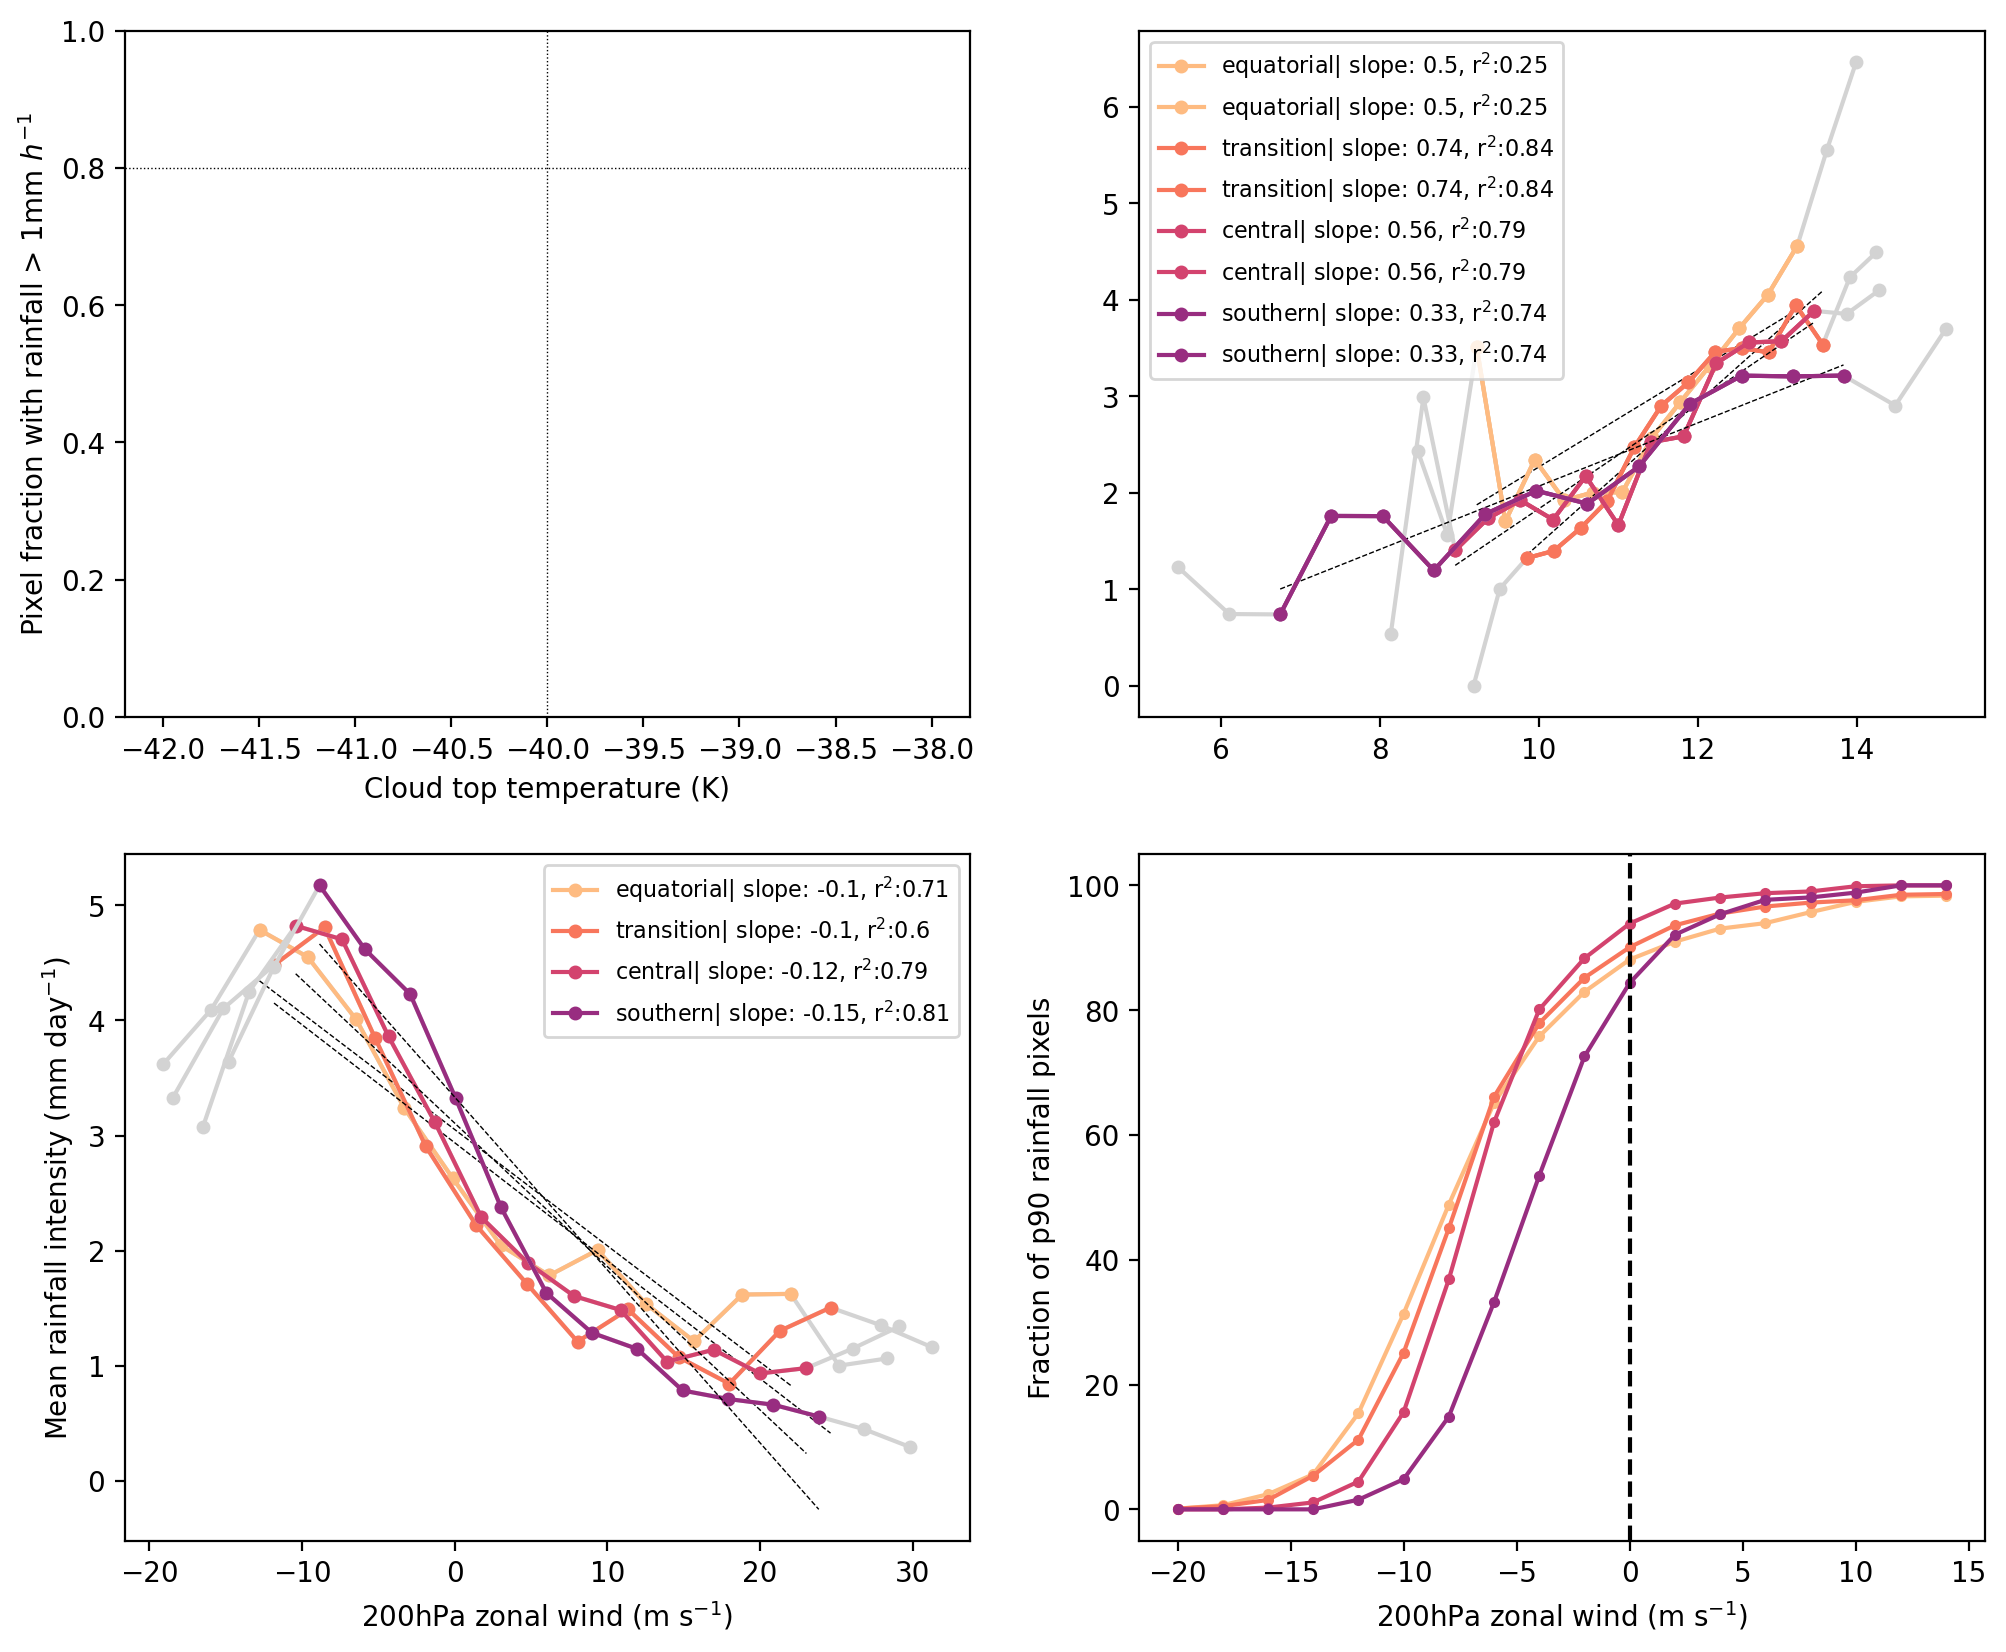

In [36]:
from endgame import hist2d

f = plt.figure(figsize=(12,10), dpi=200)
#ax = f.add_subplot(2,2,ids+1)
ax2 = f.add_subplot(221)
ax4 = f.add_subplot(222)
ax = f.add_subplot(223)
ax3 = f.add_subplot(224)
#ax3 = f.add_subplot(133)
for ids, r in enumerate(regions.keys()):
    
    alls = regions[r]
    doys_s = np.round(alls[1][0])
    doys_e = np.round(alls[1][1])
    era_region = u200ca['u'].sel(latitude=slice(alls[0][0], alls[0][1]), time =((u200ca['time.dayofyear']>=doys_s) | (u200ca['time.dayofyear']<=doys_e))).where((topo_on_g>2000)).mean(['latitude', 'longitude'])
    chirps_region = cau200.sel(latitude=slice(alls[0][0], alls[0][1]), time =((cau200['time.dayofyear']>=doys_s) | (cau200['time.dayofyear']<=doys_e))).where((topo_on_g>2000)).mean(['latitude', 'longitude'])
    
    era_region_gr = u200gr.sel(latitude=slice(alls[0][0], alls[0][1]), time =((u200gr['time.dayofyear']>=doys_s) | (u200gr['time.dayofyear']<=doys_e))).where((topo_on_g>2000)).mean(['latitude', 'longitude'])
    grid_region = grid200.sel(latitude=slice(alls[0][0], alls[0][1]), time =((grid200['time.dayofyear']>=doys_s) | (grid200['time.dayofyear']<=doys_e))).where((topo_on_g>2000)).mean(['latitude', 'longitude'])
    
    erav_region = v850ca['v'].sel(latitude=slice(alls[0][0], alls[0][1]), longitude=slice(lonsample[ids][0], lonsample[ids][1]), time =((v850ca['time.dayofyear']>=doys_s) | (v850ca['time.dayofyear']<=doys_e))).where((topo_on_g<1500)).mean(['latitude', 'longitude'])
    eraq_region = q850ca['q'].sel(latitude=slice(alls[0][0], alls[0][1]), longitude=slice(lonsample[ids][0], lonsample[ids][1]), time =((q850ca['time.dayofyear']>=doys_s) | (q850ca['time.dayofyear']<=doys_e))).where((topo_on_g<1500)).mean(['latitude', 'longitude'])*1000
  
    mask = np.isfinite(era_region) #& (chirps_region > 0.01) 
    mask_gr = np.isfinite(era_region_gr) & (grid_region < -15)
    #xbins = np.arange(-18,19,2)
    #ipdb.set_trace()
    q1 = 0.1
    q2 = 99.9
    xbins = np.percentile(era_region.values[mask], [0.1]+list(np.arange(5,96,5))+[99.9])
    xbins = np.linspace(np.percentile(era_region.values[mask],q1) ,np.percentile(era_region.values[mask],q2),17)
    
    cbins = np.arange(-80,-10,2)#np.percentile(grid_region.values[mask_gr], [0.1]+list(np.arange(5,96,5))+[99.9])
    
    dic = hist2d.var2_binning_mean(era_region.values[mask],chirps_region.values[mask],xbins)
    chperc = np.percentile(era_region_gr.values[mask_gr], 90)
    dicgrid = hist2d.var2_binning_threshold(grid_region.values[mask_gr], era_region_gr.values[mask_gr], cbins, gt=1, lt=None)
    
    ax.plot(dic['xbins'], dic['y'], marker='o', markersize=4, color='lightgrey')
    
    stx = 2
    ste = -2
    
    intercept, slope, r_value,rpearson, ppearson = weighted_regress(dic['xbins'][stx:ste],dic['y'][stx:ste],dic['ycount'][stx:ste] )
    ax.plot(dic['xbins'][stx:ste], dic['y'][stx:ste], label=r+'| slope: '+str(np.round(slope,2))+r', r$^2$:'+str(np.round(r_value**2,2)), marker='o', markersize=4, color=colord[ids])
    ax.plot(dic['xbins'][stx:ste],slope*(dic['xbins'][stx:ste])+intercept, linestyle='dashed', color='k', linewidth=0.5)
    
    #######################
  
    #xbins = np.percentile(eraq_region.values[mask], [0.1]+list(np.arange(5,96,5))+[99.9])
    
    xbins = np.linspace(8,14.5,17)
    mask = np.isfinite(eraq_region) 
    xbins = np.linspace(np.percentile(eraq_region.values[mask],q1) ,np.percentile(eraq_region.values[mask],q2),17)
    dic = hist2d.var2_binning_mean(eraq_region.values[mask],chirps_region.values[mask],xbins)
    ax4.plot(dic['xbins'], dic['y'], marker='o', markersize=4, color='lightgrey')
    stx = 2
    ste = -2
    
    intercept, slope, r_value,rpearson, ppearson = weighted_regress(dic['xbins'][stx:ste],dic['y'][stx:ste],dic['ycount'][stx:ste] )
    ax4.plot(dic['xbins'][stx:ste], dic['y'][stx:ste], label=r+'| slope: '+str(np.round(slope,2))+r', r$^2$:'+str(np.round(r_value**2,2)), marker='o', markersize=4, color=colord[ids])
    ax4.plot(dic['xbins'][stx:ste],slope*(dic['xbins'][stx:ste])+intercept, linestyle='dashed', color='k', linewidth=0.5)
    
    ax4.plot(dic['xbins'][stx:ste], dic['y'][stx:ste], label=r+'| slope: '+str(np.round(slope,2))+r', r$^2$:'+str(np.round(r_value**2,2)), marker='o', markersize=4, color=colord[ids])
    
    ####################
    


    ax.set_xlabel('200hPa zonal wind (m s$^{-1}$)')
    ax2.set_xlabel('Cloud top temperature (K)')
    ax.set_ylabel('Mean rainfall intensity (mm day$^{-1}$)')
    ax2.set_ylabel('Pixel fraction with rainfall > 1mm $h^{-1}$')
    
    cbins = np.arange(-20,15.1,2)
    dicgrid = hist2d.var2_binning_threshold_CDF(era_region.values[mask],chirps_region.values[mask], cbins, gt=np.percentile(chirps_region.values[mask],90))
    ax3.plot(dicgrid['xbins'], np.array(dicgrid['y'])*100, marker='o', markersize=3, color=colord[ids])
    
    ax3.set_xlabel('200hPa zonal wind (m s$^{-1}$)')
    ax3.set_ylabel('Fraction of p90 rainfall pixels')
    
    
ax.legend(fontsize=8)
ax4.legend(fontsize=8)
ax2.axvline(-40, linestyle='dotted', linewidth=0.5, color='k')
ax2.axhline(0.8, linestyle='dotted', linewidth=0.5, color='k')
ax3.axvline(0, linestyle='dashed', color='k')
#ax2.legend(fontsize=8)
#ax2.set_ylim(-50,-25)
#ax3.legend()
#plt.savefig('/home/ck/DIR/cornkle/figs/HUARAZ/paper/figS01.jpg')

/home/ck/pythonWorkspace/proj_CEH/endgame/hist2d.py:432: RuntimeWarning: invalid value encountered in true_divide
  outdic['y'].append(np.sum(yvar[mask]>gt)/float(np.sum(np.isfinite(yvar[mask]))))
/home/ck/pythonWorkspace/proj_CEH/endgame/hist2d.py:432: RuntimeWarning: invalid value encountered in true_divide
  outdic['y'].append(np.sum(yvar[mask]>gt)/float(np.sum(np.isfinite(yvar[mask]))))
/home/ck/pythonWorkspace/proj_CEH/endgame/hist2d.py:432: RuntimeWarning: invalid value encountered in true_divide
  outdic['y'].append(np.sum(yvar[mask]>gt)/float(np.sum(np.isfinite(yvar[mask]))))
/home/ck/pythonWorkspace/proj_CEH/endgame/hist2d.py:432: RuntimeWarning: invalid value encountered in true_divide
  outdic['y'].append(np.sum(yvar[mask]>gt)/float(np.sum(np.isfinite(yvar[mask]))))


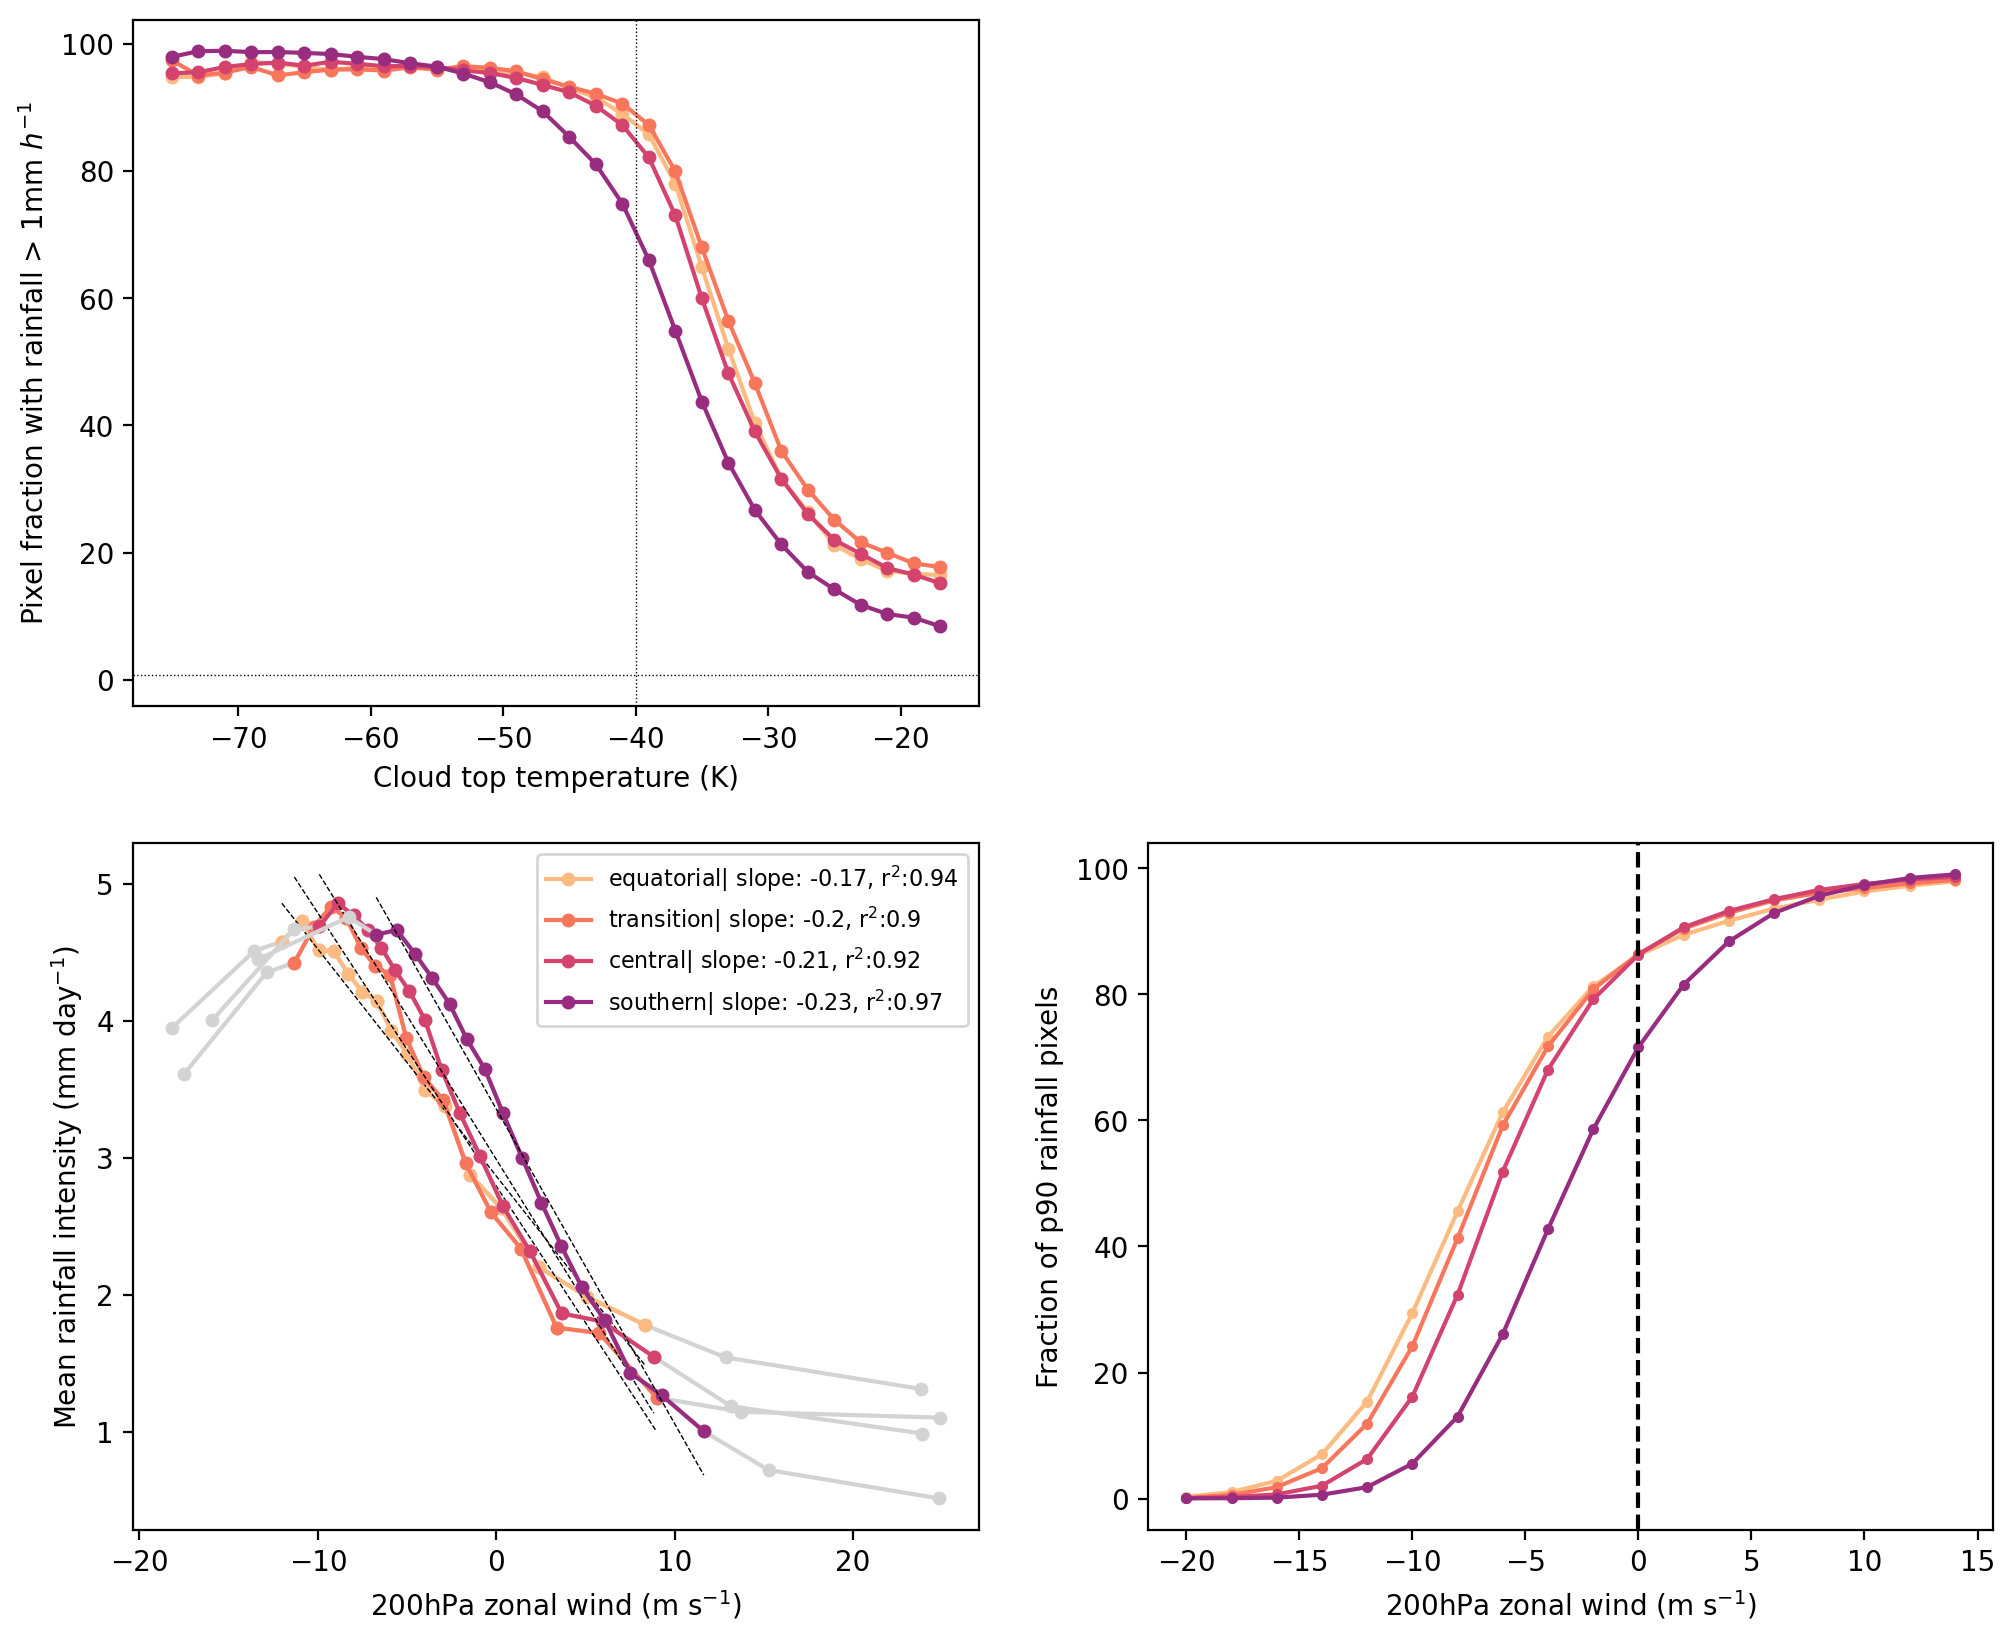

In [28]:
from endgame import hist2d

f = plt.figure(figsize=(12,10), dpi=200)
#ax = f.add_subplot(2,2,ids+1)
ax2 = f.add_subplot(221)
ax = f.add_subplot(223)
ax3 = f.add_subplot(224)
#ax3 = f.add_subplot(133)
for ids, r in enumerate(regions.keys()):
    
    alls = regions[r]
    doys_s = np.round(alls[1][0])
    doys_e = np.round(alls[1][1])
    era_region = u200ca['u'].sel(latitude=slice(alls[0][0], alls[0][1]), time =((u200ca['time.dayofyear']>=doys_s) | (u200ca['time.dayofyear']<=doys_e))).where((topo_on_g>2000))
    chirps_region = cau200.sel(latitude=slice(alls[0][0], alls[0][1]), time =((cau200['time.dayofyear']>=doys_s) | (cau200['time.dayofyear']<=doys_e))).where((topo_on_g>2000))
    
    era_region_gr = u200gr.sel(latitude=slice(alls[0][0], alls[0][1]), time =((u200gr['time.dayofyear']>=doys_s) | (u200gr['time.dayofyear']<=doys_e))).where((topo_on_g>2000))
    grid_region = grid200.sel(latitude=slice(alls[0][0], alls[0][1]), time =((grid200['time.dayofyear']>=doys_s) | (grid200['time.dayofyear']<=doys_e))).where((topo_on_g>2000))

    mask = np.isfinite(era_region) #& (chirps_region > 0.01) 
    mask_gr = np.isfinite(era_region_gr) & (grid_region < -15)
    #xbins = np.arange(-18,19,2)
    #ipdb.set_trace()
    xbins = np.percentile(era_region.values[mask], [0.1]+list(np.arange(5,96,5))+[99.9])
    
    cbins = np.arange(-80,-10,2)#np.percentile(grid_region.values[mask_gr], [0.1]+list(np.arange(5,96,5))+[99.9])
    
    dic = hist2d.var2_binning_mean(era_region.values[mask],chirps_region.values[mask],xbins)
    chperc = np.percentile(era_region_gr.values[mask_gr], 90)
    dicgrid = hist2d.var2_binning_threshold(grid_region.values[mask_gr], era_region_gr.values[mask_gr], cbins, gt=1, lt=None)
    
    ax.plot(dic['xbins'], dic['y'], marker='o', markersize=4, color='lightgrey')
    
    stx = 2
    ste = -2
    
    intercept, slope, r_value,rpearson, ppearson = weighted_regress(dic['xbins'][stx:ste],dic['y'][stx:ste],dic['ycount'][stx:ste] )
    ax.plot(dic['xbins'][stx:ste], dic['y'][stx:ste], label=r+'| slope: '+str(np.round(slope,2))+r', r$^2$:'+str(np.round(r_value**2,2)), marker='o', markersize=4, color=colord[ids])
    ax.plot(dic['xbins'][stx:ste],slope*(dic['xbins'][stx:ste])+intercept, linestyle='dashed', color='k', linewidth=0.5)
    

    ax2.plot(dicgrid['xbins'][stx:ste], np.array(dicgrid['y'][stx:ste])*100, label=r+' | slope: '+str(np.round(slope,2))+r', r$^2$:'+str(np.round(r_value**2,2)), marker='o', markersize=4, color=colord[ids])

    

    ax.set_xlabel('200hPa zonal wind (m s$^{-1}$)')
    ax2.set_xlabel('Cloud top temperature (K)')
    ax.set_ylabel('Mean rainfall intensity (mm day$^{-1}$)')
    ax2.set_ylabel('Pixel fraction with rainfall > 1mm $h^{-1}$')
    
    cbins = np.arange(-20,15.1,2)
    dicgrid = hist2d.var2_binning_threshold_CDF(era_region.values[mask],chirps_region.values[mask], cbins, gt=np.percentile(chirps_region.values[mask],90))
    ax3.plot(dicgrid['xbins'], np.array(dicgrid['y'])*100, marker='o', markersize=3, color=colord[ids])
    
    ax3.set_xlabel('200hPa zonal wind (m s$^{-1}$)')
    ax3.set_ylabel('Fraction of p90 rainfall pixels')
    
    
ax.legend(fontsize=8)
ax2.axvline(-40, linestyle='dotted', linewidth=0.5, color='k')
ax2.axhline(0.8, linestyle='dotted', linewidth=0.5, color='k')
ax3.axvline(0, linestyle='dashed', color='k')
#ax2.legend(fontsize=8)
#ax2.set_ylim(-50,-25)
#ax3.legend()
#plt.savefig('/home/ck/DIR/cornkle/figs/HUARAZ/paper/figS01.jpg')

/home/ck/miniconda3/lib/python3.7/site-packages/dask/array/numpy_compat.py:41: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/home/ck/miniconda3/lib/python3.7/site-packages/dask/array/numpy_compat.py:41: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/home/ck/miniconda3/lib/python3.7/site-packages/dask/array/numpy_compat.py:41: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/home/ck/miniconda3/lib/python3.7/site-packages/dask/array/numpy_compat.py:41: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
No handles with labels found to put in legend.
No handles with labels found to put in legend.


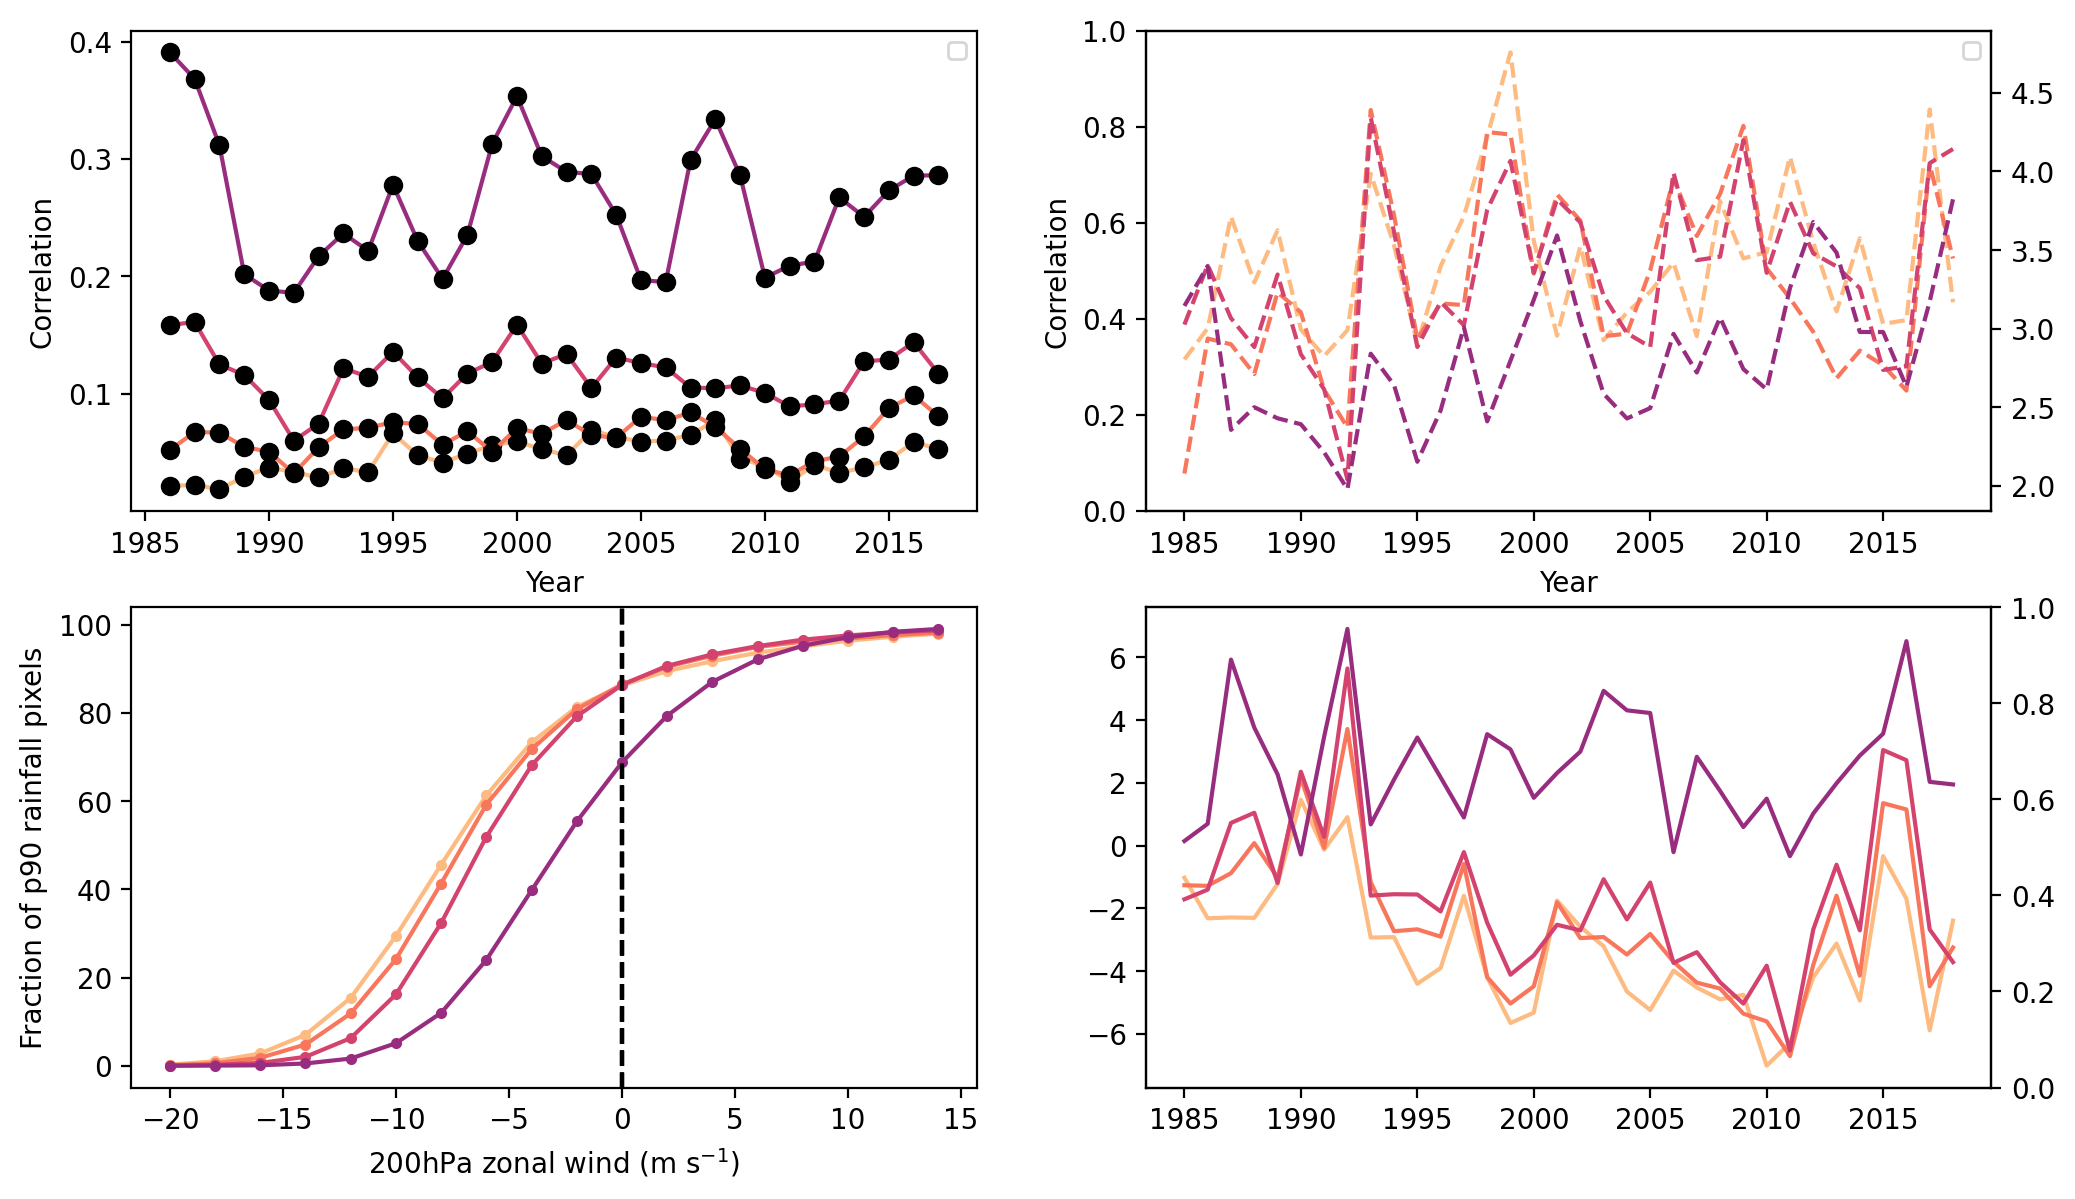

In [31]:
from endgame import hist2d

f = plt.figure(figsize=(12,7), dpi=200)
#ax = f.add_subplot(2,2,ids+1)
ax = f.add_subplot(221)
ax2 = f.add_subplot(222)
ax22 = ax2.twinx()
ax3 = f.add_subplot(223)
ax4 = f.add_subplot(224)
ax44 = ax4.twinx()
for ids, r in enumerate(regions.keys()):
    
    alls = regions[r]
    doys_s = np.round(alls[1][0])
    doys_e = np.round(alls[1][1])
    era_region = u200ca['u'].sel(latitude=slice(alls[0][0], alls[0][1]), time =((u200ca['time.dayofyear']>=doys_s) | (u200ca['time.dayofyear']<=doys_e))).where((topo_on_g>2000))
    chirps_region = cau200.sel(latitude=slice(alls[0][0], alls[0][1]), time =((cau200['time.dayofyear']>=doys_s) | (cau200['time.dayofyear']<=doys_e))).where((topo_on_g>2000))
    
    era_region_gr = u200gr.sel(latitude=slice(alls[0][0], alls[0][1]), time =((u200gr['time.dayofyear']>=doys_s) | (u200gr['time.dayofyear']<=doys_e))).where((topo_on_g>2000))
    grid_region = grid200.sel(latitude=slice(alls[0][0], alls[0][1]), time =((grid200['time.dayofyear']>=doys_s) | (grid200['time.dayofyear']<=doys_e))).where((topo_on_g>2000))
    
    era_region = era_region#.mean(['latitude', 'longitude'])
    chirps_region_max = chirps_region#.quantile(0.9,['latitude', 'longitude'])
    chirps_region = chirps_region#.quantile(0.9,['latitude', 'longitude'])#quantile(0.9, ['latitude', 'longitude'])
    
    era_region_gr = era_region_gr#.mean(['latitude', 'longitude'])  #.max(['latitude', 'longitude'])
    grid_region = grid_region#.max(['latitude', 'longitude'])
    
    
    maskm = np.isfinite(era_region) #& (chirps_region_max>=1)

    rs = []
    prs = []
    for yy in np.unique(era_region['time.year'])[2::]:
        er = era_region.sel(time=((era_region['time.year']>yy-3)&(era_region['time.year']<=yy))).mean(['latitude', 'longitude'])
        ch = chirps_region.sel(time=((chirps_region['time.year']>yy-3)&(chirps_region['time.year']<=yy))).mean(['latitude', 'longitude'])
        mask = np.isfinite(er) #& (ch>=0.5)
        
        intercept, slope, r_value,rpearson, ppearson = weighted_regress(er.values[mask],ch.values[mask])
        rval, pval = stats.pearsonr(er.values[mask], ch.values[mask])

        rs.append(rval**2)
        prs.append(pval)
        
    
    ymean = np.unique(era_region['time.year'])[1:-1]

    ax.plot(ymean, rs, markersize=4, color=colord[ids])
    spos = np.array(prs)<=0.05
    #ipdb.set_trace()
    ax.plot(ymean[spos], np.array(rs)[spos], marker='o', linestyle='', color='k')
    ax.set_title('Correlation 200hPa u wind and CHIRPS mean rainfall, daily basis per year')
    
    emean = era_region.groupby('time.year').mean().mean(['latitude', 'longitude'])
    cmean = chirps_region.groupby('time.year').mean().mean(['latitude', 'longitude'])
    gmean = grid_region.groupby('time.year').mean().mean(['latitude', 'longitude'])
    #ax2.plot(np.unique(era_region['time.year']), emean*-1, color=colord[ids])
    ax22.plot(np.unique(era_region['time.year']),cmean, color=colord[ids], linestyle='dashed')
    ax.set_title('200hPa wind and Mean chirps rainfall per year (dynamic correlation period)')
    
    cbins = np.arange(-20,15.1,2)
    dicgrid = hist2d.var2_binning_threshold_CDF(era_region.values[maskm],chirps_region_max.values[maskm], cbins, gt=np.percentile(chirps_region_max.values[maskm],90))
    ax3.plot(dicgrid['xbins'], np.array(dicgrid['y'])*100, marker='o', markersize=3, color=colord[ids])
    ax3.axvline(0, linestyle='dashed', color='k')
    ax3.set_xlabel('200hPa zonal wind (m s$^{-1}$)')
    ax3.set_ylabel('Fraction of p90 rainfall pixels')
    
    ax4.plot(np.unique(era_region['time.year']), emean, color=colord[ids])
    ax4.set_title('200hPa wind timeseries')
    #ax44.plot(np.unique(era_region['time.year']),gmean, color=colord[ids], linestyle='dashed')



    ax.set_xlabel('Year')
    ax2.set_xlabel('Year')
    ax.set_ylabel('Correlation')
    ax2.set_ylabel('Correlation')
    
    
ax.legend(fontsize=8)
ax2.legend(fontsize=8)
#ax2.set_ylim(-50,-25)
#ax3.legend()

In [32]:
enso = '/home/ck/DIR/mymachine/ENSO/ONI.csv'
ens = pd.read_csv(enso, sep=',', engine='python', names=np.arange(0, 13),index_col=0)
thresh=0.4
picks = ens.copy()
picks[ens<=-thresh]=-1
picks[ens>=thresh]=1
picks[(ens>=-thresh) & (ens<=thresh)] = 0
recent = ens.loc[1985:2018]
dti = pd.date_range('1985-01-01', periods=408, freq='m')

In [34]:
ensy = [1987, 1992, 1997, 2002,2015,2016]

(-2.5, 2.5)

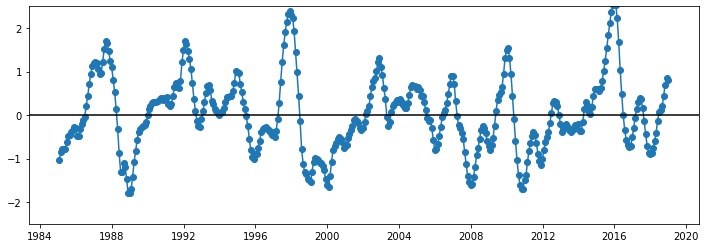

In [35]:
f = plt.figure(figsize=(12,4))
ax = f.add_subplot(111)
plt.plot(dti,recent.values.flatten(), marker='o')
plt.axhline(0, color='k')
ax.set_ylim(-2.5,2.5)

In [37]:
# f = plt.figure(figsize=(12,7), dpi=200)
# #ax = f.add_subplot(2,2,ids+1)
# trends = [[],[],[],[]]
# trendr = [[],[],[],[]]
# trendp = [[],[],[],[]]
# for ids, r in enumerate(regions.keys()):
    
#     alls = regions[r]
#     doys_s = np.round(alls[1][0])
#     doys_e = np.round(alls[1][1])
#     era_region = u200ca['u'].sel(latitude=slice(alls[0][0], alls[0][1]), time =((u200ca['time.dayofyear']>=doys_s) | (u200ca['time.dayofyear']<=doys_e))).where((topo_on_g>2000)).mean(['latitude', 'longitude'])
#     chirps_region = cau200.sel(latitude=slice(alls[0][0], alls[0][1]), time =((cau200['time.dayofyear']>=doys_s) | (cau200['time.dayofyear']<=doys_e))).where((topo_on_g>2000)).mean(['latitude', 'longitude'])
#     years = np.unique(chirps_region['time.year'])
#     for yy in np.unique(chirps_region['time.dayofyear']):
        
        
#         ch = chirps_region.sel(time=((chirps_region['time.dayofyear']==yy)))
#         #ipdb.set_trace()
#         if len(ch)!=len(years):
#             print('Not same number of entries as years, continue')
#             continue
        
#         intercept, slope, r_value,rpearson, ppearson = weighted_regress(years, ch,np.isfinite(ch))

#         trends[ids].append(slope)
#         trendr[ids].append(rpearson)
#         trendp[ids].append(ppearson)
        

In [38]:
# dic = {'trends' : trends, 'r' : trendr, 'pval' : trendp}

In [39]:
# import pickle as pkl
# pkl.dump(dic, open("/home/ck/DIR/cornkle/figs/HUARAZ/saves/chirps_doy_trends_perRegion"+".p", "wb"))

In [33]:
import pickle as pkl
trenddic = pkl.load(open("/home/ck/DIR/cornkle/figs/HUARAZ/saves/chirps_doy_trends_perRegion"+".p", "rb"))

In [5]:

for ids, r in enumerate(regions.keys()):
    (trenddic['pval'])[ids]

dict_keys(['trends', 'r', 'pval'])

In [34]:
def moving_average(x, w):
    return np.convolve(x, np.ones(w), 'valid') / w

In [ ]:
f = plt.figure(figsize=(12,7), dpi=200)
#ax = f.add_subplot(2,2,ids+1)
ax = f.add_subplot(111)
for ids, r in enumerate(regions.keys()):
    alls = regions[r]
    doys_s = np.round(alls[1][0])
    doys_e = np.round(alls[1][1])
    nrange = np.arange(doys_s-365,doys_e+1)
    nrall = np.arange(doys_s-365,doys_e+1)
    posis = np.where(np.array((trenddic['pval'])[ids])<0.05)[0]
  #  ipdb.set_trace()
    print(nrange.shape)
    print(len((trenddic['trends'])[ids]))
    ipdb.set_trace()
    ax.plot(nrange, moving_average((trenddic['trends'])[ids],10), label=r)
    
    #ax.scatter(nrall[posis],[ids/100]*len(posis))
    ax.set_xticks([-120,-90,-60,-30,0,30,60,90,120,150])
    ax.axvline(0, color='k')
plt.legend()

(267,)
314
> <ipython-input-35-73116ef822c5>(15)<module>()
     14     ipdb.set_trace()
---> 15     ax.plot(nrange, moving_average((trenddic['trends'])[ids],10), label=r)
     16 



In [ ]:
from endgame import hist2d

f = plt.figure(figsize=(12,7), dpi=200)
#ax = f.add_subplot(2,2,ids+1)
ax = f.add_subplot(221)
ax2 = f.add_subplot(222)
ax22 = ax2.twinx()
ax3 = f.add_subplot(223)
ax4 = f.add_subplot(224)
ax44 = ax4.twinx()
for ids, r in enumerate(regions.keys()):
    
    alls = regions[r]
    doys_s = np.round(alls[1][0])
    doys_e = np.round(alls[1][1])
    era_region = u200ca['u'].sel(latitude=slice(alls[0][0], alls[0][1]), time =((u200ca['time.dayofyear']>=doys_s) | (u200ca['time.dayofyear']<=doys_e))).where((topo_on_g>2000))
    chirps_region = cau200.sel(latitude=slice(alls[0][0], alls[0][1]), time =((cau200['time.dayofyear']>=doys_s) | (cau200['time.dayofyear']<=doys_e))).where((topo_on_g>2000))
    
    maskm = np.isfinite(era_region) #& (chirps_region_max>=1)
    p90 = np.percentile(chirps_region.values[maskm],90)

    rs = []
    prs = []
    for yy in np.unique(era_region['time.year'])[2::]:
        er = era_region.sel(time=((era_region['time.year']>yy-3)&(era_region['time.year']<=yy))).mean(['latitude', 'longitude']).rolling(time=3, min_periods=2, center=True).mean()
        ch = chirps_region.sel(time=((chirps_region['time.year']>yy-3)&(chirps_region['time.year']<=yy))).mean(['latitude', 'longitude']).rolling(time=3, min_periods=2, center=True).mean()
        mask = np.isfinite(er)  & (er<=10) & (er>=-10)
        
        #intercept, slope, r_value,rpearson, ppearson = weighted_regress(er.values[mask],ch.values[mask])
        rval, pval = stats.pearsonr(er.values[mask], ch.values[mask])

        rs.append(rval**2)
        prs.append(pval)
        
    
    ymean = np.unique(era_region['time.year'])[1:-1]

    ax.plot(ymean, rs, markersize=4, color=colord[ids])
    spos = np.array(prs)<=0.01
    #ipdb.set_trace()
    ax.plot(ymean[spos], np.array(rs)[spos], marker='o', linestyle='', color='k', ms=1)
    
    
    emean = era_region.where((era_region<=10) & (era_region>=-10)).groupby('time.year').mean().mean(['latitude', 'longitude'])
    cmean = chirps_region.where((era_region<=10) & (era_region>=-10)).groupby('time.year').mean().mean(['latitude', 'longitude'])
#     cmean = chirps_region.where(chirps_region>=p90).groupby('time.year').sum().mean(['latitude', 'longitude'])
#     cbase = chirps_region.groupby('time.year').sum().mean(['latitude', 'longitude'])
#     cextr = cmean/cbase*100
  
    ax2 = f.add_subplot(2,2,ids+1)
    ax22 = ax2.twinx()
    ax2.plot(np.unique(era_region['time.year']), emean*-1, color=colord[ids])
    intercept, slope, r_value,rpearson, ppearson = weighted_regress(emean, cmean,np.isfinite(cmean))
    ax.set_title('u wind (solid) versus chirps mean domain rain (dashed)')
    ax22.plot(np.unique(era_region['time.year']),cmean, color=colord[ids], linestyle='dashed',  label=r+' | slope: '+str(np.round(slope,2))+r', r$^2$:'+str(np.round(r_value**2,2)))
#     for ys in ensy:
#         ax22.scatter(ys, cmean.sel(year=ys), color='k')
    #intercept, slope, r_value,rpearson, ppearson = weighted_regress(np.unique(era_region['time.year']), cextr,np.isfinite(cextr))
    #ax22.plot(np.unique(era_region['time.year']),slope*np.unique(era_region['time.year'])+intercept, linestyle='dashed', color='k', linewidth=0.5,  label=r+' | slope: '+str(np.round(slope,2))+r', r$^2$:'+str(np.round(r_value**2,2)))
    ax22.legend(fontsize=8)

    
#     ax4.plot(np.unique(era_region['time.year']), emean*-1, color=colord[ids])
#     #ax44.plot(np.unique(era_region['time.year']),gmean, color=colord[ids], linestyle='dashed')



    ax.set_xlabel('Year')
    ax2.set_xlabel('Year')
    ax.set_ylabel('Correlation')
    ax2.set_ylabel('Correlation')
    

ax.legend(fontsize=8)
#ax2.legend(fontsize=8)
#ax2.set_ylim(-50,-25)
#ax3.legend()

4.847339472772875 -2.086256643440178 0.30287980661338865 -0.5503451591446056 0.000745610845849502
5.462178275799353 -2.48600528070468 0.3354525282580507 -0.5791826262553416 0.000331934374138619
11.25320337201595 -3.7000618128182925 0.6061585874442248 -0.7785618654436484 5.913776055060511e-08
8.798390005008649 -2.173197544186572 0.28582161521004357 -0.5346229103059331 0.0011249850152714824


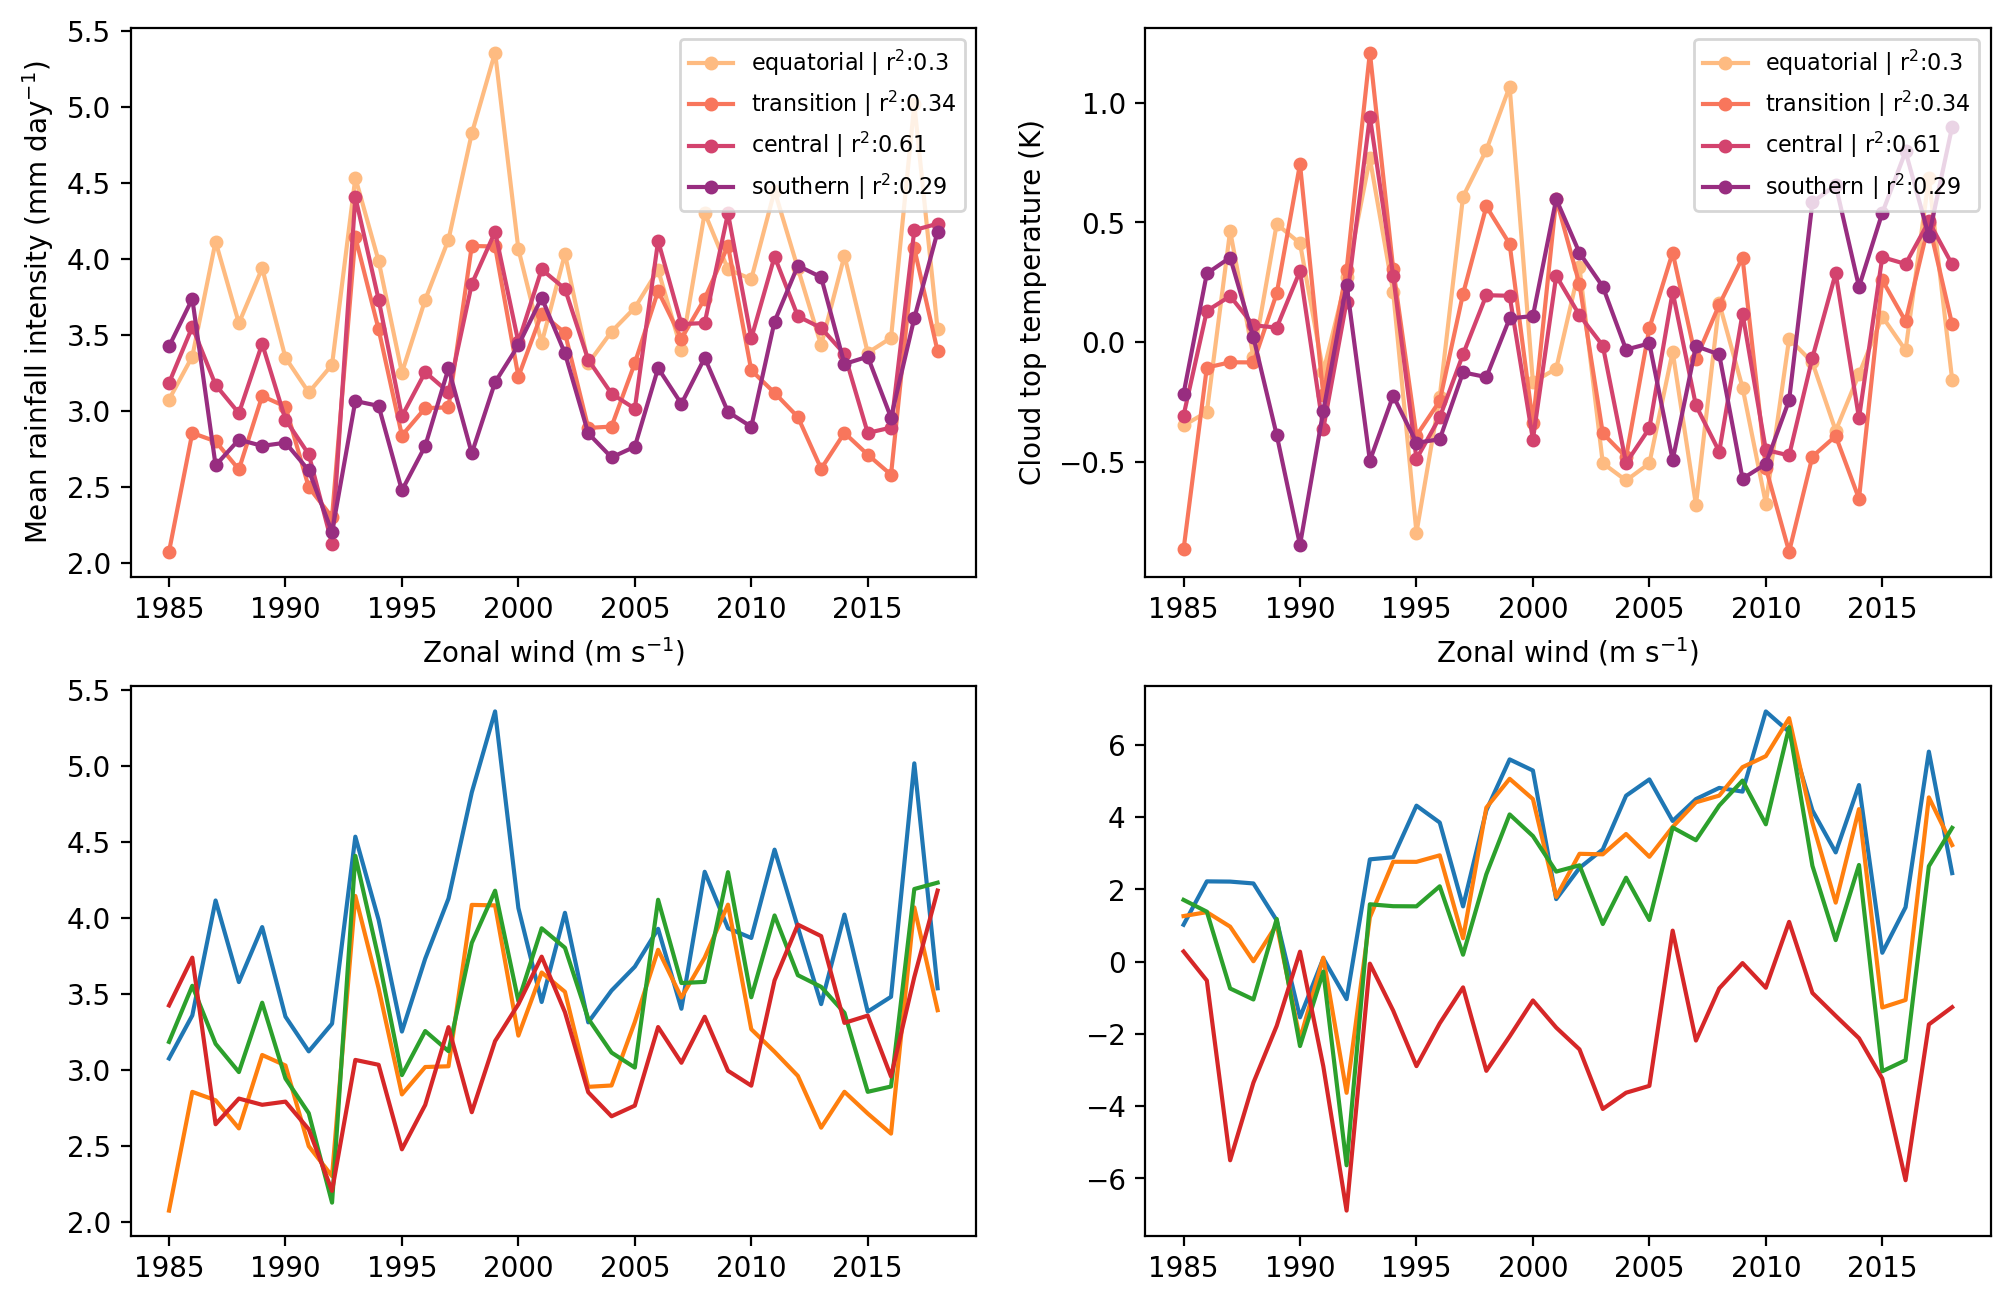

In [74]:
from endgame import hist2d
lonsample = [(-77.25, -73.75), (-76.25, -72.75), (-74.5, -71.0), (-66.0, -62.5)] # eq, trans, centr, south

f = plt.figure(figsize=(12,8), dpi=200)
#ax = f.add_subplot(2,2,ids+1)
ax = f.add_subplot(221)
ax2 = f.add_subplot(222)
ax3 = f.add_subplot(223)
ax4 = f.add_subplot(224)
for ids, r in enumerate(regions.keys()):
    
    alls = regions[r]
    doys_s = np.round(alls[1][0])
    doys_e = np.round(alls[1][1])
    era_region = u200ca['u'].sel(latitude=slice(alls[0][0], alls[0][1]), time =((u200ca['time.dayofyear']>=doys_s) | (u200ca['time.dayofyear']<=doys_e))).where((topo_on_g>1500))
    era_region = u200ca['u'].sel(latitude=slice(alls[0][0], alls[0][1]), time =((u200ca['time.dayofyear']>=doys_s) | (u200ca['time.dayofyear']<=doys_e))).where((topo_on_g>1500))
    chirps_region = cau200.sel(latitude=slice(alls[0][0], alls[0][1]), time =((cau200['time.dayofyear']>=doys_s) | (cau200['time.dayofyear']<=doys_e))).where((topo_on_g>1500))
    
    era_region_gr = u200gr.sel(latitude=slice(alls[0][0], alls[0][1]), time =((u200gr['time.dayofyear']>=doys_s) | (u200gr['time.dayofyear']<=doys_e))).where((topo_on_g>1500))
    grid_region = grid200.sel(latitude=slice(alls[0][0], alls[0][1]), time =((grid200['time.dayofyear']>=doys_s) | (grid200['time.dayofyear']<=doys_e))).where((topo_on_g>1500))

    mask = np.isfinite(era_region) #& (chirps_region > 0.01) 
    mask_gr = np.isfinite(era_region_gr) & (grid_region < -15)
    #xbins = np.arange(-18,19,2)
    #ipdb.set_trace()
    xbins = np.percentile(era_region.values[mask], [0.1]+list(np.arange(5,96,5))+[99.9])
    
    cbins = np.arange(-80,-10,2)#np.percentile(grid_region.values[mask_gr], [0.1]+list(np.arange(5,96,5))+[99.9])
    
    dic = hist2d.var2_binning_mean(era_region.values[mask],chirps_region.values[mask],xbins)

    stx = 2
    ste = -2
    intercept, slope, r_value,rpearson, ppearson = weighted_regress(dic['xbins'][stx:ste],dic['y'][stx:ste],dic['ycount'][stx:ste] )
     
    ts_reconstruct = era_region.copy(deep=True)
    ts_reconstruct.values = slope*(ts_reconstruct.values)+intercept
    
    xxch = chirps_region.mean(['latitude', 'longitude']).groupby(chirps_region['time.year']).mean().load()#.rolling(year=3, min_periods=2, center=True).mean()
    xxera = ts_reconstruct.mean(['latitude', 'longitude']).groupby(ts_reconstruct['time.year']).mean().load()#.rolling(year=3, min_periods=2, center=True).mean()
    rawera = era_region.mean(['latitude', 'longitude']).groupby(ts_reconstruct['time.year']).mean().load()
    #rawera= (rawera.where(rawera<-2).groupby(era_region['time.year']).count()/rawera.groupby(era_region['time.year']).count())*100#.rolling(year=3, min_periods=2, center=True).mean()
    
    isfin = np.isfinite(xxch)&np.isfinite(xxera)
    
    intercept2, slope2, r_value2,rpearson2, ppearson2 = weighted_regress(xxch,rawera)
    
    print(intercept2, slope2, r_value2,rpearson2, ppearson2)
    
    #ipdb.set_trace()
    
    ax.plot(np.unique(chirps_region['time.year']), xxch, label=r+" | r$^{2}$:"+str(np.round(stats.pearsonr(xxch[isfin], xxera[isfin])[0]**2,2)), marker='o', markersize=4, color=colord[ids])
    
    #ts_reconstruct = slope*(xxera)+intercept
    isfin = np.isfinite(xxch)&np.isfinite(rawera)
    ax2.plot(np.unique(chirps_region['time.year']), xxch-xxera, label=r+" | r$^{2}$:"+str(np.round(stats.pearsonr(xxch[isfin], rawera[isfin])[0]**2,2)), marker='o', markersize=4, color=colord[ids])
    

    ax.set_xlabel('Zonal wind (m s$^{-1}$)')
    ax2.set_xlabel('Zonal wind (m s$^{-1}$)')
    ax.set_ylabel('Mean rainfall intensity (mm day$^{-1}$)')
    ax2.set_ylabel('Cloud top temperature (K)')
    
    ax3.plot(np.unique(chirps_region['time.year']),xxch)

    ax4.plot(np.unique(chirps_region['time.year']),rawera*-1)
    
#     hist, count, h = u_stats.histo_frequency(chirps_region.values[mask], bins=np.arange(0,20,0.1))
#     ax3.plot(np.arange(0,19.9,0.1),hist, label=r, color=colord[ids])
#     ax3.set_yscale('log')
    
ax.legend(fontsize=8)
ax2.legend(fontsize=8)
#ax2.set_ylim(-50,-25)
#ax3.legend()

In [61]:
def perc_1d_binning(data, xvar, xbins):
    import warnings
    """
    :param xvar: xvar of the 2dhist
    :param yvar: yvar of the 2d hist
    :param xbins: bins to use for the xvar
    :param ybins: bins to use for the yvar
    :param varlist: dictionary of variables to put into histogram
    :param varpick: list of variables in dic to calculate
    :return:
    """
    outdic = {}
    outdic['data'] = []


    for issh, shl in enumerate(xbins[0:-1]):

        poss_ds = (xvar > shl) & (xvar <= xbins[issh + 1])
        valdat = (data[poss_ds])[np.isfinite(data[poss_ds])]
        #dat = np.percentile(valdat, perc)
        with warnings.catch_warnings():
            warnings.simplefilter("ignore", category=RuntimeWarning)
            dat = np.nanmean(valdat)

        outdic['data'].append(dat)

        #ipdb.set_trace()

    outdic['xbins'] = (np.round(xbins[0:-1]+((xbins[1::]-xbins[0:-1])/2),2))


    return outdic

In [62]:
def binning_loop(x, y):
    dic = {'corr': [], 'pval' : [], 'slope' : []}

    for ids,year in enumerate(range(1986,2019)):

        xx = x.sel(time=slice(str(year-1)+'-08-01',str(year)+'-07-30'))
        yy = y.sel(time=slice(str(year-1)+'-08-01',str(year)+'-07-30'))
        
        #ipdb.set_trace()
        
        print('Doing', year)

#         cadic = perc_1d_binning(xx,yy, xbins=np.arange(-15,15,1))
#         isval = np.isfinite(cadic['data'])
        mask = np.isfinite(xx) & np.isfinite(yy)
        b, a, r_value, p_value, std_err = linregress(xx[mask], yy[mask])
        
       # ipdb.set_trace()

        dic['corr'].append(r_value**2)
        dic['pval'].append(p_value)
        dic['slope'].append(b)
                        
    return dic

KeyboardInterrupt: 

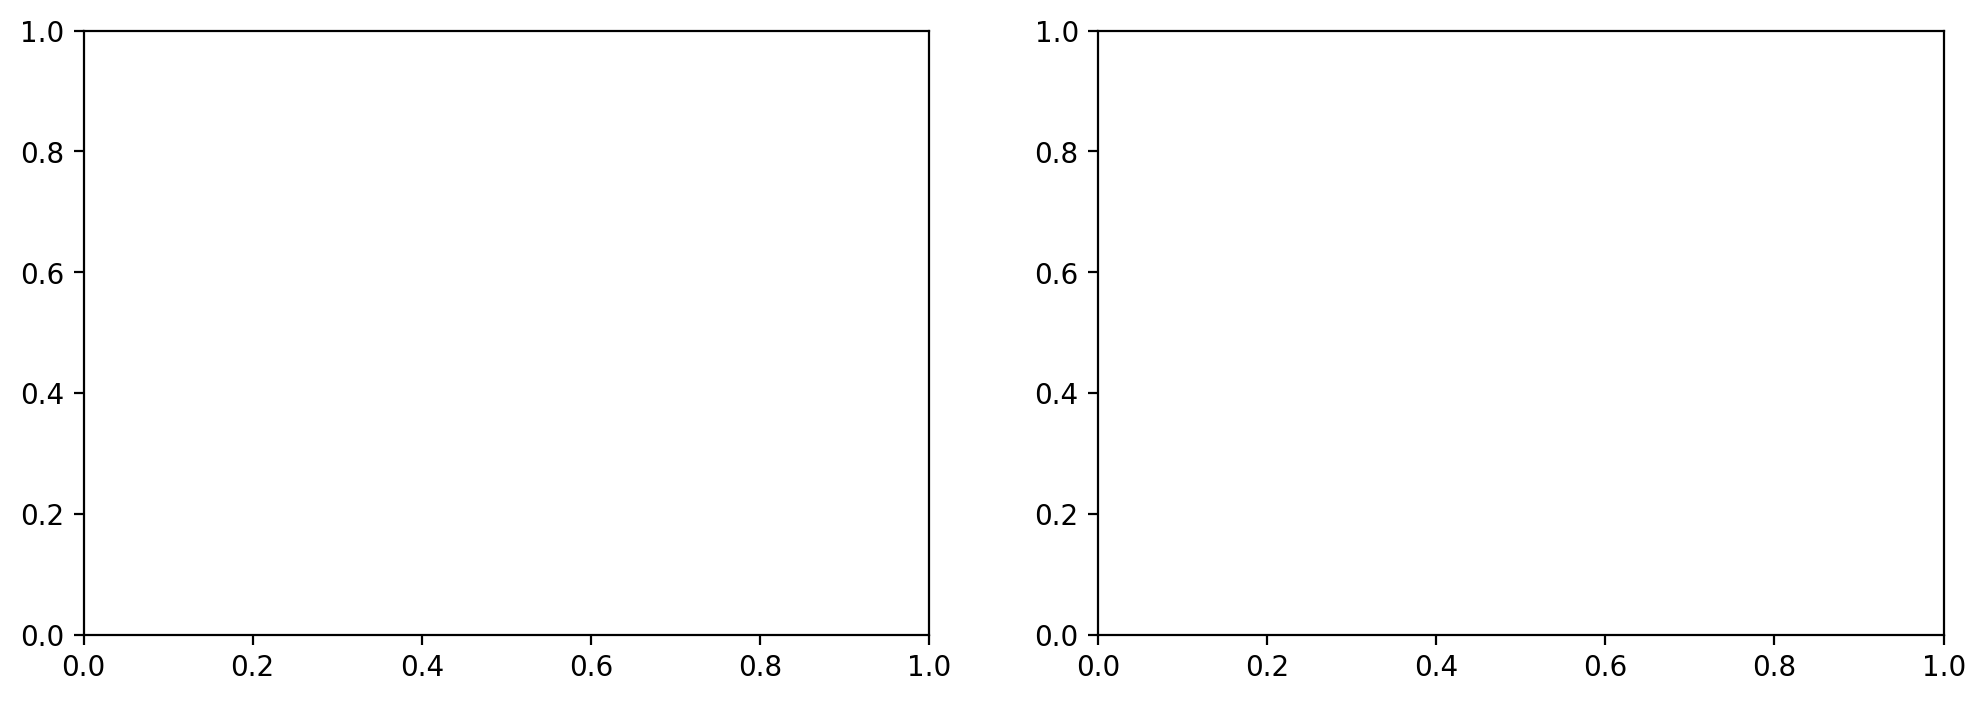

In [63]:
###chirps uwind correlation for every year

f = plt.figure(figsize=(12,4), dpi=200)
#ax = f.add_subplot(2,2,ids+1)
ax = f.add_subplot(121)
ax2 = f.add_subplot(122)
#ax3 = f.add_subplot(133)
for ids, r in enumerate(regions.keys()):
    
    alls = regions[r]
    doys_s = np.round(alls[1][0])
    doys_e = np.round(alls[1][1])
    era_region = u200ca['u'].sel(latitude=slice(alls[0][0], alls[0][1]), time =((u200ca['time.dayofyear']>=doys_s) | (u200ca['time.dayofyear']<=doys_e))).load().where((topo_on_g>2000))
    chirps_region = cau200.sel(latitude=slice(alls[0][0], alls[0][1]), time =((cau200['time.dayofyear']>=doys_s) | (cau200['time.dayofyear']<=doys_e))).load().where((topo_on_g>2000))
    
    #era_region_gr = u200ca['u'].sel(latitude=slice(alls[0][0], alls[0][1]), time =((u200gr['time.dayofyear']>=doys_s) | (u200gr['time.dayofyear']<=doys_e))).where((topo_on_g>2000))
    grid_region = u550ca['u550'].sel(latitude=slice(alls[0][0], alls[0][1]), time =((u550ca['time.dayofyear']>=doys_s) | (u550ca['time.dayofyear']<=doys_e))).load().where((topo_on_g>2000))
    
    xxch = chirps_region.mean(['latitude', 'longitude'])#.groupby(chirps_region['time.year']).mean().load().rolling(year=5, min_periods=5, center=True).mean()
    xxera = era_region.mean(['latitude', 'longitude'])#.groupby(era_region['time.year']).mean().load().rolling(year=5, min_periods=5, center=True).mean()
    xxgrid = grid_region.mean(['latitude', 'longitude'])#.groupby(grid_region['time.year']).mean().load().rolling(year=5, min_periods=5, center=True).mean()
    print('Entering first binning')
    dic = binning_loop(xxch, xxera)
    
    years = np.unique(chirps_region['time.year'])
    valposw = np.array(dic['pval'])<0.05
    xvalw  = (years[0:-1])[valposw]
    yvalw = np.array(dic['corr'])[valposw]
    
    ax.plot(years[0:-1], dic['corr'], label=r, marker='o', markersize=4, color=colord[ids])
    ax.plot(xvalw, yvalw, marker='o', markersize=4, color=colord[ids])


    ax.set_xlabel('Year')
    ax.set_ylabel('Correlation u200 chirps')

    ###########################################
    print('Entering second binning')
    dic = binning_loop(xxgrid, xxera)
    
    years = np.unique(chirps_region['time.year'])
    valposw = np.array(dic['pval'])<0.05
    xvalw  = (years[0:-1])[valposw]
    yvalw = np.array(dic['corr'])[valposw]
    
    ax.plot(years[0:-1], dic['corr'], label=r, marker='o', markersize=4, color=colord[ids])
    ax.plot(xvalw, yvalw, marker='o', markersize=4, color=colord[ids])


    ax.set_xlabel('Year')
    ax.set_ylabel('Correlation u200 u550')

#     hist, count, h = u_stats.histo_frequency(chirps_region.values[mask], bins=np.arange(0,20,0.1))
#     ax3.plot(np.arange(0,19.9,0.1),hist, label=r, color=colord[ids])
#     ax3.set_yscale('log')
    
ax.legend(fontsize=8)
#ax2.legend(fontsize=8)
#ax2.set_ylim(-50,-25)
#ax3.legend()